In [1]:
import sys
sys.path.append("../src/")

# Enable hot autoreload
%load_ext autoreload
%autoreload 2

In [16]:
import torch
import matplotlib.pyplot as plt
from transformers import LlamaTokenizer, LlamaForCausalLM
from utils import compute_perplexity
from datasets import load_from_disk
from collections import defaultdict
from tqdm.notebook import tqdm
import random

In [3]:
LLAMA_TOKENIZER_PATH = "<LLAMA_TOKENIZER_PATH>"
LLAMA_MODEL_PATH = "<LLAMA_MODEL_PATH>"

DATASET_PATH = "<DATASET_PATH>"

In [ ]:
tokenizer = LlamaTokenizer.from_pretrained(LLAMA_TOKENIZER_PATH, torch_dtype=torch.float16)
tokenizer.pad_token = tokenizer.eos_token

model = LlamaForCausalLM.from_pretrained(LLAMA_MODEL_PATH)
model = model.to("cuda:1")

In [44]:
dataset = load_from_disk(DATASET_PATH)
dataset = dataset.map(
    lambda samples: tokenizer(samples["text"]),
    batched=False,
    num_proc=92,
)

dataset = dataset.filter(
    lambda x: len(x["input_ids"]) > 5000,
    num_proc=92,
)

In [ ]:
perplexities = defaultdict(list)
N_SAMPLES = 1000
SEQ_LEN_SET = (25, 50, 100)

for seq_len in SEQ_LEN_SET:
    for _ in tqdm(range(N_SAMPLES)):
        doc_id = random.choice(range(len(dataset)))
        doc = dataset[doc_id]

        if len(doc["input_ids"]) < seq_len:
            continue

        start_idx = random.choice(range(len(doc["input_ids"]) - seq_len + 1))
        input_ids = torch.tensor(doc["input_ids"][start_idx:start_idx + seq_len]).unsqueeze(0).to("cuda:1")
        attention_mask = torch.tensor(doc["attention_mask"][start_idx:start_idx + seq_len]).unsqueeze(0).to("cuda:1")

        ppl = compute_perplexity(model, input_ids, attention_mask)
        perplexities[seq_len].append(ppl.item())

    

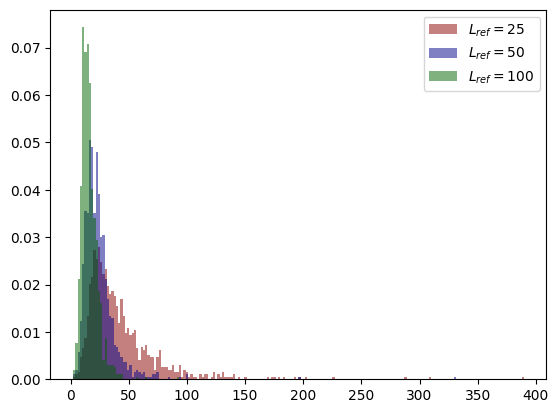

In [72]:
_, bins, _ = plt.hist(perplexities[25], bins=200, density=True, alpha=0.5, label=r"$L_{ref}=25$", color="darkred")
plt.hist(perplexities[50], bins=bins, density=True, alpha=0.5, label=r"$L_{ref}=50$", color="darkblue")
plt.hist(perplexities[100], bins=bins, density=True, alpha=0.5, label=r"$L_{ref}=100$", color="darkgreen")
plt.legend()